# Scotland Whiskey Analysis 2017 

#### A co-relation between multiple qualities of whiskey samples collected from distilleries in Scotland.


The generated graph will then be plotted along a geographic plot.

# Step-1

## Import the necessary libraries

pandas - Database management

numpy - Optimized Numerical Calculations

sklearn - Data Science libraries

bokeh, matplotlib - plotting graphs

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster.bicluster import SpectralCoclustering
from time import strftime as stime
from bokeh.models import HoverTool, ColumnDataSource
from bokeh.io import output_file
from bokeh.plotting import figure, show
import os
from random import randint

# Step-2

## Define important file names

These filenames will be required later in the code

### "n_classes" stores the number of classifications of whiskey
### "flavor_index" stores the index numbers of the flavors

In [2]:
file_whiskies="whiskies.txt"
file_regions="regions.txt"
filename = "whiskies_with_regions.txt"
new_filename = "NEW_whiskies_with_regions.txt"

flavor_index=list(range(2,14))
n_clusters=6

# Step-3

## Load the databases and combine them into one

The new database is now stored in "whiskies_with_regions.txt"

We do so using the pandas library.


In [3]:
whiskey = pd.read_csv(file_whiskies)
region = pd.read_csv("regions.txt")

whiskey['Region'] = region

whiskey.to_csv(filename, index=False)
print("New file created as: "+filename)

New file created as: whiskies_with_regions.txt


# Step-4

## Generate the correlation matrix

### What is a Correlation Matrix?

A correlation matrix is a table showing correlation coefficients between sets of variables. Each random variable (Xi) in the table is correlated with each of the other values in the table (Xj). This allows you to see which pairs have the highest correlation.


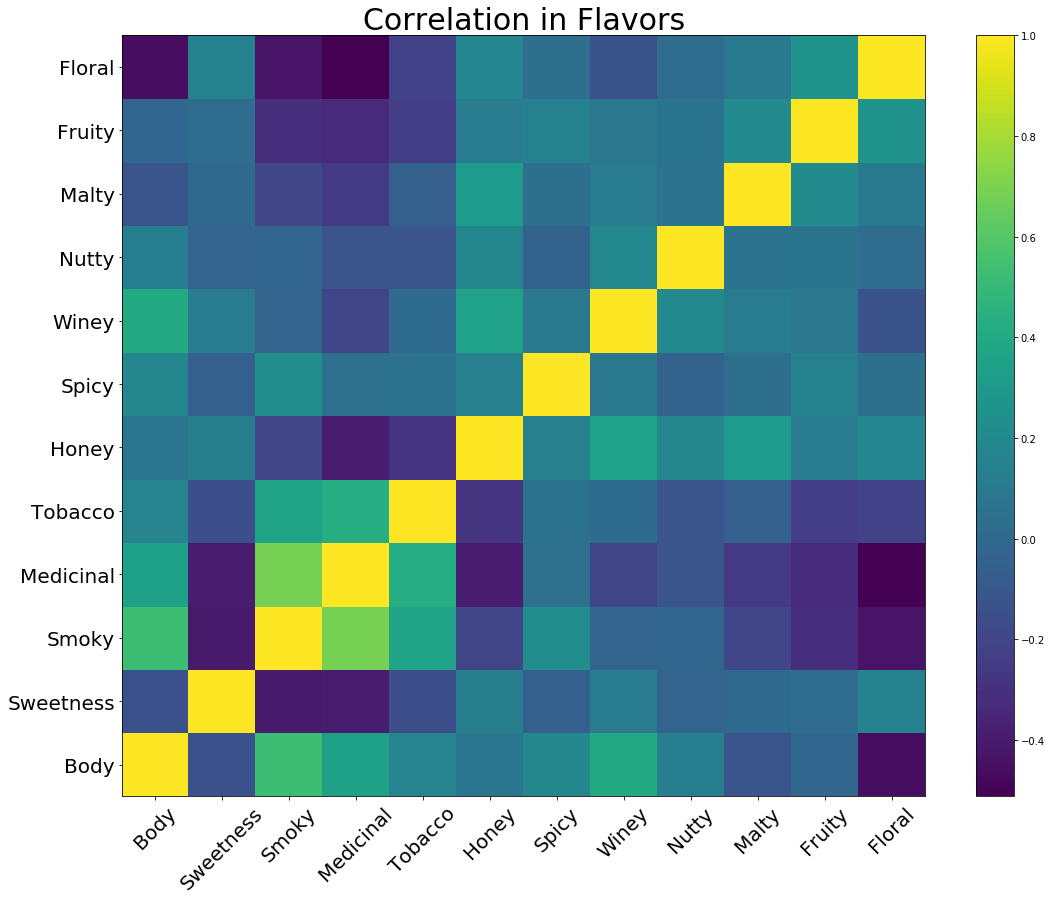

In [4]:
flavors = whiskey.iloc[:, flavor_index ]
corr_list = pd.DataFrame.corr( flavors ) #correlation of whiskies

labels = corr_list.index

fig, ax = plt.subplots()
fig.set_figheight(14)
fig.set_figwidth(18)

im = ax.pcolor(corr_list)
fig.colorbar(im)

ax.tick_params(labelsize=20)

for axis in [ax.xaxis, ax.yaxis]:
    axis.set(ticks=np.arange(0.5, len(labels)), ticklabels=labels)
plt.xticks(rotation=45)
plt.axis("tight")

if not os.path.exists("Static Plots"):
    os.makedirs("Static Plots")

plt.title("Correlation in Flavors", fontsize=30)
plt.savefig("Static Plots/flavored-co-clusters__" + stime("%d-%m-%Y_%H-%M-%S") + ".pdf")
plt.show()

# Step-5

## Arrange the generated matrix

We try to cluster the distillaries into "n_classes" groups based on similar features of whiskies produced by them. Then we arrange the matrix in such a way that those clusters are placed together, showing visible "n_classes" regions along the diagonal in the generated plot.


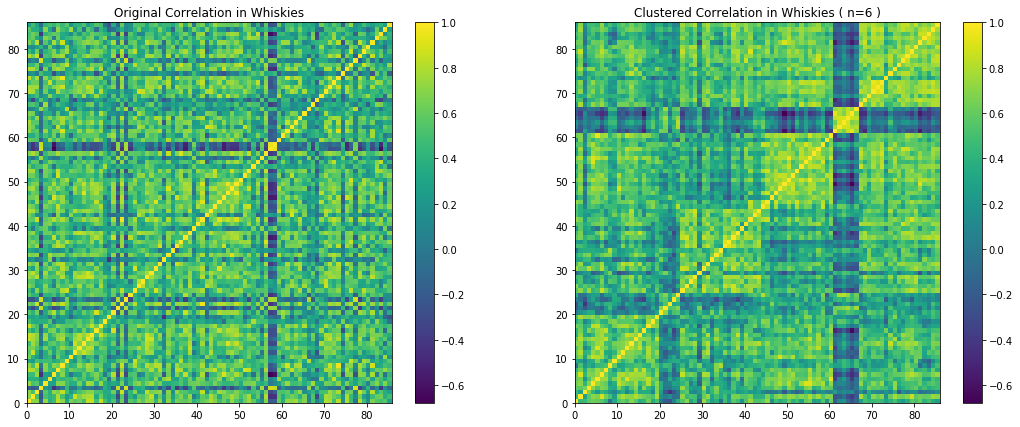

Clustered database stored in: NEW_whiskies_with_regions.txt


In [5]:
corr_list = pd.DataFrame.corr( flavors.transpose() ) #correlation of whiskies

plt.figure(figsize=(18,7))

plt.subplot(121)
plt.pcolor(corr_list)
plt.colorbar()
plt.title("Original Correlation in Whiskies")
plt.axis("tight")


clustered_model = SpectralCoclustering(n_clusters = n_clusters, random_state=0)
clustered_model.fit(corr_list)

feed = clustered_model.row_labels_

# Updating the whiskey database with a new column for their group/cluster
whiskey["Group"] = pd.Series(feed, index=whiskey.index)
whiskey = whiskey.iloc[np.argsort(clustered_model.row_labels_)]
whiskey = whiskey.reset_index(drop=True)


flavors = whiskey.iloc[:, flavor_index ]
corr_list = pd.DataFrame.corr( flavors.transpose() ) #correlation of whiskies

correlations = np.array( corr_list )

plt.subplot(122)
plt.pcolor(correlations)
plt.colorbar()
plt.title("Clustered Correlation in Whiskies ( n=" + str(n_clusters) + " )")
plt.axis("tight")



if not os.path.exists("Static Plots"):
    os.makedirs("Static Plots")

plt.savefig("Static Plots/co-clusters__" + stime("%d-%m-%Y_%H-%M-%S") + ".pdf")
plt.show()

whiskey.to_csv(new_filename, index=False)
print("Clustered database stored in: " + new_filename)

# Step-6

## Plot the clustered-correlations clearly in an interactive plot




##### We'll be using Bokeh library for plotting the interactive graph





## First we assign random colors to each cluster



In [6]:
cluster_colors = []
for i in range(n_clusters):
    c = "#%06x" % randint(0, 0x777777)
    cluster_colors.append(c)

cluster_colors

['#331372', '#64e03b', '#2fbd0d', '#549731', '#6e7429', '#305c0f']

## We use bokeh to plot the same graph in a clearer and interative way

In [7]:
distilleries = list(whiskey.Distillery)

correlation_colors = []

for i in range(len(distilleries)):
    for j in range(len(distilleries)):

        if correlations[i,j]  < .70:        
            correlation_colors.append('white')         
        else:                                          
            if whiskey.Group[i] == whiskey.Group[j]:              
                correlation_colors.append(cluster_colors[whiskey.Group[i]])
            else:                                      
                correlation_colors.append('lightgray')

source = ColumnDataSource(
    data = {
        "x": np.repeat(distilleries,len(distilleries)),
        "y": list(distilleries)*len(distilleries),
        "colors": correlation_colors,
        "alphas": correlations.flatten(),
        "correlations": correlations.flatten(),
    }
)

if not os.path.exists("Interactive Clustered Plots"):
    os.makedirs("Interactive Clustered Plots")

output_file("Interactive Clustered Plots\Whisky Correlations.html", title="Whisky Correlations")

fig = figure(title = "Whisky Correlations",
    x_axis_location = "above",
    tools = "hover,save",
    x_range = list(reversed(distilleries)),
    y_range = distilleries)

fig.grid.grid_line_color = None
fig.axis.axis_line_color = None
fig.axis.major_tick_line_color = None
fig.axis.major_label_text_font_size = "5pt"
fig.xaxis.major_label_orientation = np.pi / 3

fig.rect('x', 'y', .9, .9, source=source, color='colors', alpha='alphas')

hover = fig.select(dict(type=HoverTool))
hover.tooltips = { "Whiskies": "@x, @y", "Correlation": "@correlations",}

show(fig)

# Step-7

## Plot an interactive geographic plot based on one specfied parameter




##### We'll be using the "Group" or cluster as the default parameter of coloring.


## First, assign random colors to each category


In [8]:
based_on="Group"
basis = whiskey[based_on]

cluster_colors = []
for i in range( len(basis) ):
    c = "#%06x" % randint(0, 0xFFFFFF)
    cluster_colors.append(c)


## Plot the interactive geographic plot using bokeh library


In [9]:
region_colors = dict( zip(basis, cluster_colors) )
colors = [region_colors[i] for i in list(whiskey[based_on])]

if not os.path.exists("Interactive Geo-Plots"):
    os.makedirs("Interactive Geo-Plots")

title = "Interactive Geo-Plots\Geo-plot-based-on-"+based_on+"__"+ stime("%d-%m-%Y_%H-%M-%S") + ".html"

output_file(title)

data={
        "x": whiskey[" Latitude"],
        "y": whiskey[" Longitude"],
        "colors": colors,
        "regions": whiskey.Region,
        "distilleries": whiskey.Distillery,
        "group": whiskey.Group
    }

source = ColumnDataSource( data )

fig = figure(title = "Distillery Map", x_axis_location = "above", tools="hover, save")

fig.plot_width  = 800
fig.plot_height = 1000

fig.circle("x", "y", size=9, source=source, color='colors', line_color = None)

fig.xaxis.major_label_orientation = np.pi / 3

hover = fig.select(dict(type = HoverTool))
if based_on == "Group":
    hover.tooltips = { "Distillery": "@distilleries", "Location": "(@x, @y)", "Region": "@regions" }
else:
    hover.tooltips = { "Distillery": "@distilleries", "Location": "(@x, @y)" }

show(fig)